In [226]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [227]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [228]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set() # seaborn 속성을 기본값으로 설정

In [229]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

class Cols:
    ID = 'ID'
    crim = "crim"
    zn = "zn"
    indus='indus'
    chas = 'chas'
    nox = 'nox'
    rm = 'rm'
    age = 'age'
    dis = 'dis'
    rad = 'rad'
    tax = 'tax'
    ptratio = 'ptratio'
    black = 'black'
    lstat = 'lstat'
    medv = 'medv'
    


In [230]:
print(train.shape[0])
print(test.shape[0])
train.head()

333
173


,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


분석을 위해 train/test를 합친다.
train의 갯수를 저장해 둔다.(나중에 분리해야 하므로)

In [231]:
train_len = train.shape[0]

merged = train.append(test, ignore_index=True, sort=False) 
print("merged len : ", merged.shape[0])

merged len :  506


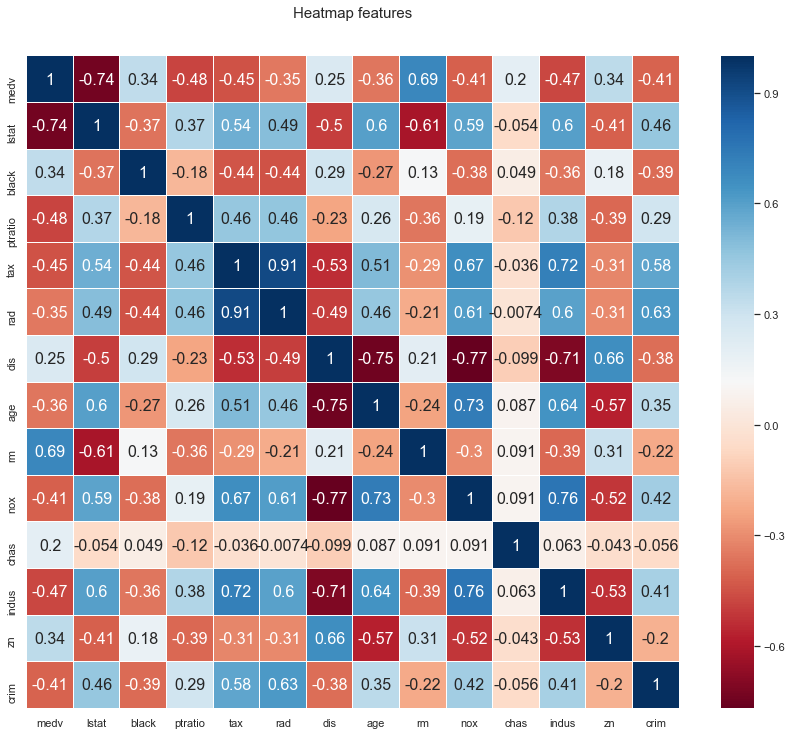

In [232]:
heatmap_data = merged[[Cols.medv, Cols.lstat, Cols.black, Cols.ptratio, Cols.tax, Cols.rad, Cols.dis, Cols.age, Cols.rm, Cols.nox, Cols.chas, Cols.indus, Cols.zn, Cols.crim]]

colormap = plt.cm.RdBu
plt.figure(figsize=(15,12))
plt.title('Heatmap features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":16})


상관관계 분석을 보고 관련이 적어 보이는 것은 없애자

In [233]:
if Cols.chas in merged:
    merged = merged.drop([Cols.chas], axis=1)
if Cols.black in merged:
    merged = merged.drop([Cols.black], axis=1)
if Cols.zn in merged:
    merged = merged.drop([Cols.zn], axis=1)
if Cols.dis in merged:
    merged = merged.drop([Cols.dis], axis=1)
if Cols.rad in merged:
    merged = merged.drop([Cols.rad], axis=1)
if Cols.age in merged:
    merged = merged.drop([Cols.age], axis=1)    
merged.head()


,ID,crim,indus,nox,rm,tax,ptratio,lstat,medv
0,1,0.00632,2.31,0.538,6.575,296,15.3,4.98,24.0
1,2,0.02731,7.07,0.469,6.421,242,17.8,9.14,21.6
2,4,0.03237,2.18,0.458,6.998,222,18.7,2.94,33.4
3,5,0.06905,2.18,0.458,7.147,222,18.7,5.33,36.2
4,7,0.08829,7.87,0.524,6.012,311,15.2,12.43,22.9


scaling

In [234]:
from sklearn.preprocessing import MinMaxScaler

class NoColumnError(Exception):
    """Raised when no column in dataframe"""
    def __init__(self, value):
        self.value = value
    # __str__ is to print() the value
    def __str__(self):
        return(repr(self.value))

# normalize AgeGroup
def normalize_column(data, columnName, minval=0, maxval=1):
    scaler = MinMaxScaler(feature_range=(minval, maxval))    
    if columnName in data:
        aaa = scaler.fit_transform(data[columnName].values.reshape(-1, 1)) # 입력을 2D 데이터로 넣어야 하므로 reshape해 준다.
        aaa = aaa.reshape(-1,) # 다시 원복해서 넣어주지만, 그냥 넣어도 알아서 제대로 들어간다...
        data[columnName] = aaa
        return data
    else:
        raise NoColumnError(str(columnName) + " is not exists!")

def normalize(dataset, columns, minval, maxval):
    for col in columns:
        dataset = normalize_column(dataset, col, minval, maxval)
    return dataset

In [235]:
merged.head()

,ID,crim,indus,nox,rm,tax,ptratio,lstat,medv
0,1,0.00632,2.31,0.538,6.575,296,15.3,4.98,24.0
1,2,0.02731,7.07,0.469,6.421,242,17.8,9.14,21.6
2,4,0.03237,2.18,0.458,6.998,222,18.7,2.94,33.4
3,5,0.06905,2.18,0.458,7.147,222,18.7,5.33,36.2
4,7,0.08829,7.87,0.524,6.012,311,15.2,12.43,22.9


crim의 경우 min/max 차가 크므로 log 연산을 취한다.

0.00632 88.9762
-5.064036070823371 4.488368918239841


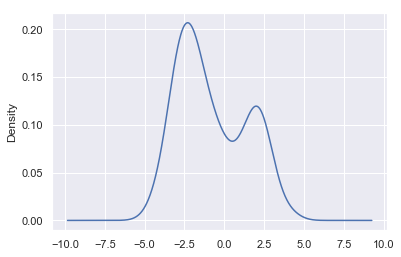

In [236]:
print(merged[Cols.crim].min(), merged[Cols.crim].max())
merged[Cols.crim] = merged[Cols.crim].map(lambda i : np.log(i))
print(merged[Cols.crim].min(), merged[Cols.crim].max())
merged[Cols.crim].plot.kde()

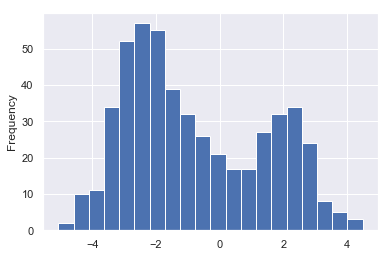

In [237]:
merged[Cols.crim].plot.hist(bins=20)

nox값은 전체 값이 모두 0보다 작으므로 10을 곱해서 값을 키워 준다.

3.85 8.71


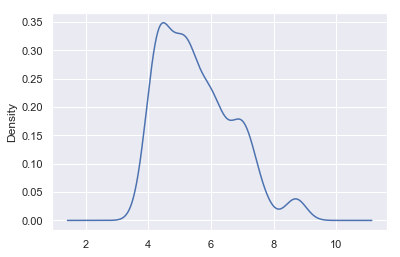

In [238]:
merged[Cols.nox] = merged[Cols.nox].map(lambda i : i * 10)
print(merged[Cols.nox].min(), merged[Cols.nox].max())
merged[Cols.nox].plot.kde()

In [239]:
merged.head(n=20)

,ID,crim,indus,nox,rm,tax,ptratio,lstat,medv
0,1,-5.064036,2.31,5.38,6.575,296,15.3,4.98,24.0
1,2,-3.600502,7.07,4.69,6.421,242,17.8,9.14,21.6
2,4,-3.430523,2.18,4.58,6.998,222,18.7,2.94,33.4
3,5,-2.672924,2.18,4.58,7.147,222,18.7,5.33,36.2
4,7,-2.427128,7.87,5.24,6.012,311,15.2,12.43,22.9
5,11,-1.492144,7.87,5.24,6.377,311,15.2,20.45,15.0
6,12,-2.141572,7.87,5.24,6.009,311,15.2,13.27,18.9
7,13,-2.366804,7.87,5.24,5.889,311,15.2,15.71,21.7
8,14,-0.462416,8.14,5.38,5.949,307,21.0,8.26,20.4
9,15,-0.449480,8.14,5.38,6.096,307,21.0,10.26,18.2


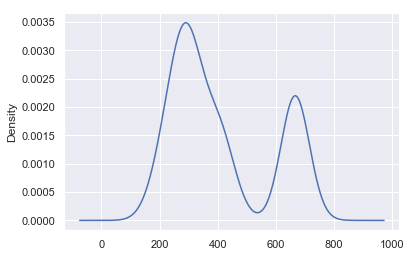

In [240]:
merged[Cols.tax].plot.kde()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


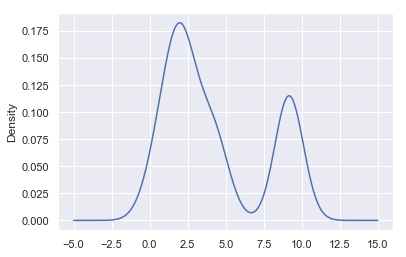

In [241]:
merged = normalize(merged, [Cols.tax], minval=0, maxval=10)
merged[Cols.tax].plot.kde()

In [242]:
merged.head()

,ID,crim,indus,nox,rm,tax,ptratio,lstat,medv
0,1,-5.064036,2.31,5.38,6.575,2.080153,15.3,4.98,24.0
1,2,-3.600502,7.07,4.69,6.421,1.049618,17.8,9.14,21.6
2,4,-3.430523,2.18,4.58,6.998,0.667939,18.7,2.94,33.4
3,5,-2.672924,2.18,4.58,7.147,0.667939,18.7,5.33,36.2
4,7,-2.427128,7.87,5.24,6.012,2.366412,15.2,12.43,22.9
